## Plot survival prediction results

In this notebook, we'll compare the results of survival prediction using [elastic net Cox regression](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxnetSurvivalAnalysis.html) for expression and methylation data only.

The files analyzed in this notebook are generated by the `run_survival_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff for pairwise comparisons (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# significance cutoff, after FDR correction
SIG_ALPHA = 0.05

# if True, save figures to images directory
SAVE_FIGS = True

In [3]:
# set results directory
me_results_dir = Path(cfg.repo_root,
                      '06_predict_survival',
                      'results_extended_alphas',
                      'results_5000_pca').resolve()
me_results_desc = 'top 5000 PCs'

# set images directory
images_dir = Path(cfg.images_dirs['survival'])

# load results into a single dataframe
me_results_df = su.load_survival_results(me_results_dir)
me_results_df.rename(columns={'identifier': 'cancer_type',
                              'fold_no': 'fold'}, inplace=True)
me_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.98206,train,UVM,me_27k,signal,42,0
1,0.98206,cv,UVM,me_27k,signal,42,0
2,0.75490,test,UVM,me_27k,signal,42,0
3,0.93543,train,UVM,me_27k,signal,42,1
4,0.93543,cv,UVM,me_27k,signal,42,1


### Check model convergence results

In the past we were having issues with model convergence for some cancer types. Let's see how frequently (if at all) this is happening.

In [4]:
me_count_df = (me_results_df[me_results_df.data_type == 'test']
    .groupby(['cancer_type', 'training_data'])
    .count()
)
problem_df = me_count_df[me_count_df['cindex'] != 16].copy()
print(len(problem_df), '/', len(me_count_df))
problem_df

19 / 99


cindex  data_type  signal  seed  fold
cancer_type training_data                                       
ACC         me_27k             12         12      12    12    12
CHOL        expression         12         12      12    12    12
            me_27k              8          8       8     8     8
            me_450k            12         12      12    12    12
DLBC        expression          4          4       4     4     4
            me_27k              4          4       4     4     4
            me_450k             4          4       4     4     4
KICH        expression          8          8       8     8     8
            me_27k              8          8       8     8     8
            me_450k             8          8       8     8     8
PCPG        expression         12         12      12    12    12
READ        expression          8          8       8     8     8
            me_27k             12         12      12    12    12
TGCT        me_27k             12         12      12    12    12
            me_450k             4          4       4     4     4
THCA        expression         12         12      12    12    12
THYM        me_27k             12         12      12    12    12
            me_450k            12         12      12    12    12
UCS         expression          8          8       8     8     8

We'll just drop these missing cancer types from our comparisons for now, although we could debug the issues with model convergence sometime in the future (e.g. by using an extended parameter range).

In [5]:
drop_cancer_types = problem_df.index.get_level_values(0).unique().values
print(drop_cancer_types)

['ACC' 'CHOL' 'DLBC' 'KICH' 'PCPG' 'READ' 'TGCT' 'THCA' 'THYM' 'UCS']


### Plot survival prediction results

We want to compare survival prediction for:
* true labels vs. shuffled labels
* between omics types
    
As a metric, for now we're just using the [censored concordance index](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.metrics.concordance_index_censored.html). Essentially, this compares the actual order of events (i.e. death or tumor progression) in the test dataset vs. the order of events predicted by the model in the test samples. A higher concordance index = better prediction.

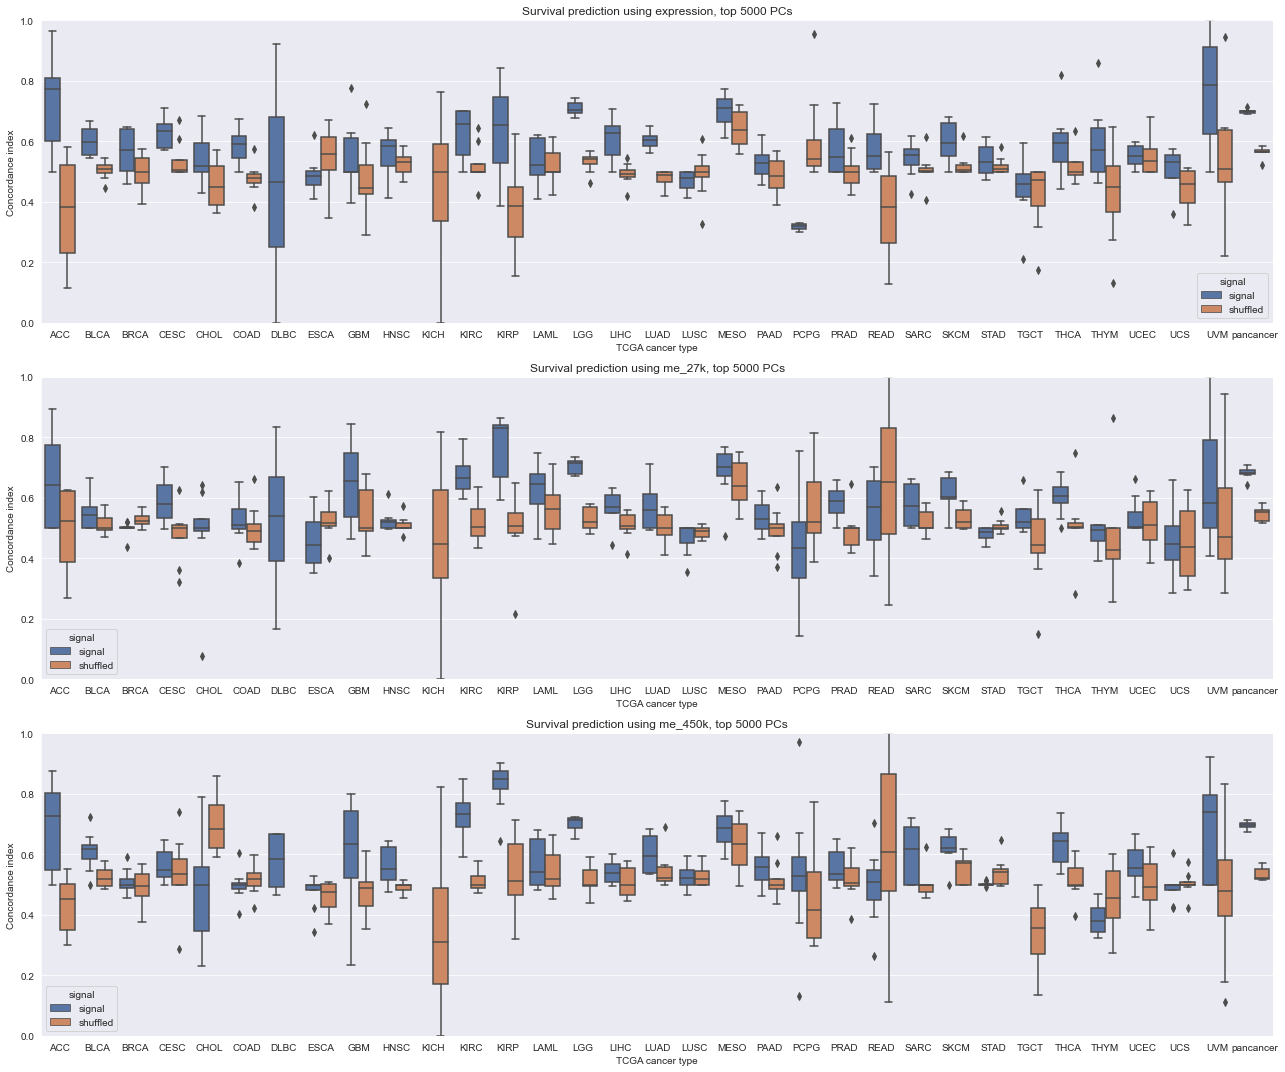

In [6]:
sns.set({'figure.figsize': (18, 15)})
fig, axarr = plt.subplots(3, 1)

for ix, data_type in enumerate(
    me_results_df.training_data.sort_values().unique()
):
    
    ax = axarr[ix]
    
    filtered_df = me_results_df[
        (me_results_df.training_data == data_type) &
        (me_results_df.data_type == 'test')
    ].copy()

    filtered_df.sort_values(by='cancer_type', inplace=True)

    sns.boxplot(data=filtered_df, x='cancer_type', y='cindex', hue='signal',
                hue_order=['signal', 'shuffled'], ax=ax)
    ax.set_xlabel('TCGA cancer type')
    ax.set_ylabel('Concordance index')
    ax.set_title('Survival prediction using {}, {}'.format(data_type,
                                                           me_results_desc))
    ax.set_ylim(0.0, 1.0)
    
plt.tight_layout()

In [7]:
me_results_df['identifier'] = (me_results_df.cancer_type + '_' +
                               me_results_df.training_data)
me_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold,identifier
0,0.98206,train,UVM,me_27k,signal,42,0,UVM_me_27k
1,0.98206,cv,UVM,me_27k,signal,42,0,UVM_me_27k
2,0.75490,test,UVM,me_27k,signal,42,0,UVM_me_27k
3,0.93543,train,UVM,me_27k,signal,42,1,UVM_me_27k
4,0.93543,cv,UVM,me_27k,signal,42,1,UVM_me_27k


In [8]:
me_compare_df = au.compare_control_ind(me_results_df,
                                       identifier='identifier',
                                       metric='cindex',
                                       verbose=True)
me_compare_df['cancer_type'] = me_compare_df.identifier.str.split('_', 1, expand=True)[0]
me_compare_df['training_data'] = me_compare_df.identifier.str.split('_', 1, expand=True)[1]

print(len(me_compare_df))
me_compare_df.head()

shapes unequal for ACC_me_27k, skipping
shapes unequal for CHOL_expression, skipping
shapes unequal for CHOL_me_27k, skipping
shapes unequal for CHOL_me_450k, skipping
shapes unequal for DLBC_expression, skipping
shapes unequal for DLBC_me_27k, skipping
shapes unequal for DLBC_me_450k, skipping
shapes unequal for KICH_expression, skipping
shapes unequal for KICH_me_27k, skipping
shapes unequal for KICH_me_450k, skipping
shapes unequal for PCPG_expression, skipping
shapes unequal for READ_me_27k, skipping


648


shapes unequal for TGCT_me_27k, skipping
shapes unequal for TGCT_me_450k, skipping
shapes unequal for THCA_expression, skipping
shapes unequal for THYM_me_27k, skipping
shapes unequal for THYM_me_450k, skipping


,identifier,seed,fold,delta_cindex,cancer_type,training_data
0,ACC_expression,42,0,0.25904,ACC,expression
1,ACC_expression,42,1,0.72391,ACC,expression
2,ACC_expression,42,2,0.26161,ACC,expression
3,ACC_expression,42,3,0.43228,ACC,expression
4,ACC_expression,1,0,0.44123,ACC,expression


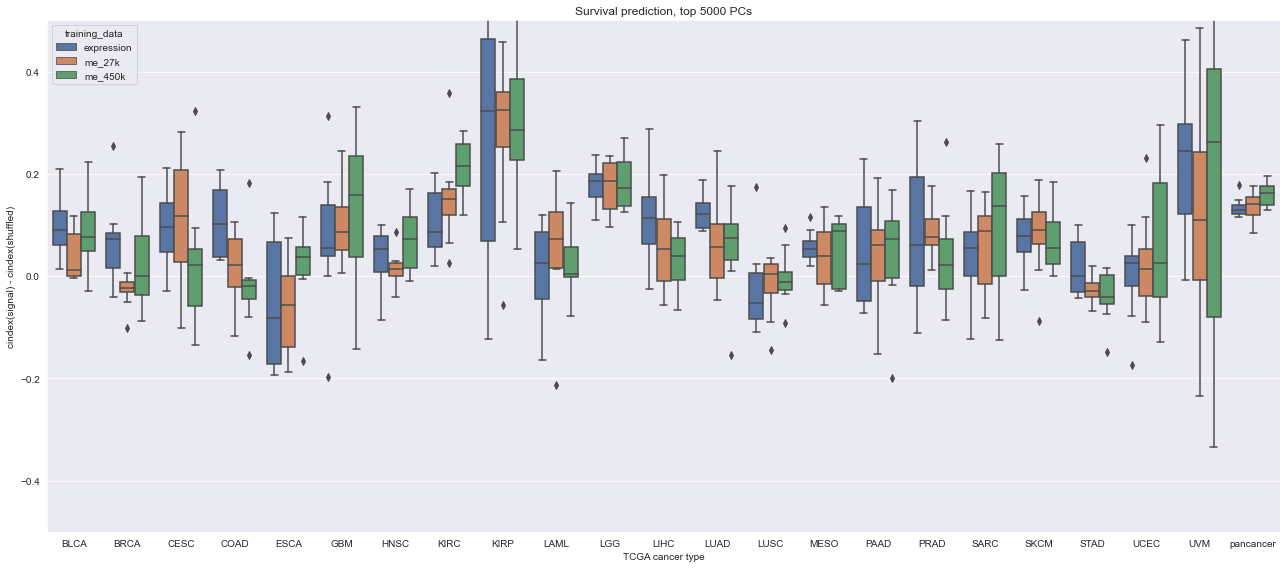

In [9]:
sns.set({'figure.figsize': (18, 8)})
    
me_compare_df.sort_values(by='cancer_type', inplace=True)

sns.boxplot(data=me_compare_df[~me_compare_df.cancer_type.isin(drop_cancer_types)],
            x='cancer_type',
            y='delta_cindex',
            hue='training_data',
            hue_order=sorted(me_compare_df.training_data.unique()))
plt.xlabel('TCGA cancer type')
plt.ylabel('cindex(signal) - cindex(shuffled)')
plt.title('Survival prediction, {}'.format(me_results_desc))
plt.ylim(-0.5, 0.5)
    
plt.tight_layout()

### Heatmap

This is similar to the heatmaps we plotted in the results script in `02_classify_mutations` for the mutation prediction problem. We want to compare data types for predicting survival in different cancer types.

A blue square means that data type significantly outperforms the baseline with shuffled survival labels in the corresponding cancer type, and a red square means the same + the results are statistically equivalent to the "best" data type for that cancer type (determined by pairwise $t$-tests).

In [10]:
me_all_results_df = au.compare_all_data_types(me_results_df[~me_results_df.cancer_type.isin(drop_cancer_types)],
                                           SIG_ALPHA,
                                           identifier='cancer_type',
                                           metric='cindex')

me_all_results_df.rename(columns={'gene': 'cancer_type'}, inplace=True)
me_all_results_df.sort_values(by='p_value').head(10)

,cancer_type,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
22,pancancer,0.160496,3.018287e-07,0.000007,True,me_450k,5.158512
22,pancancer,0.135211,3.154299e-07,0.000007,True,expression,5.139369
22,pancancer,0.135767,4.793854e-06,0.000110,True,me_27k,3.957587
10,LGG,0.177524,6.001378e-06,0.000069,True,expression,4.161051
7,KIRC,0.213374,1.667704e-05,0.000192,True,me_450k,3.717183
12,LUAD,0.124625,2.049806e-05,0.000157,True,expression,3.803681
10,LGG,0.183414,3.239143e-05,0.000248,True,me_450k,3.604963
10,LGG,0.174691,4.214596e-05,0.000485,True,me_27k,3.314546
8,KIRP,0.296839,6.944904e-04,0.003993,True,me_450k,2.398666
14,MESO,0.058138,1.254750e-03,0.007215,True,expression,2.141775


In [11]:
me_heatmap_df = (me_all_results_df
    .pivot(index='training_data', columns='cancer_type', values='delta_mean')
    .reindex(sorted(me_compare_df.training_data.unique()))
)
me_heatmap_df.iloc[:, :5]

cancer_type,BLCA,BRCA,CESC,COAD,ESCA
training_data,,,,,
expression,0.096554,0.069850,0.090910,0.107509,-0.053459
me_27k,0.038526,-0.029045,0.108960,0.014830,-0.065069
me_450k,0.085079,0.023825,0.025118,-0.017249,0.017307


In [12]:
raw_results_df = (me_results_df
    .drop(columns=['identifier'])
    .rename(columns={'cancer_type': 'identifier'})
)
raw_results_df.head()

,cindex,data_type,identifier,training_data,signal,seed,fold
0,0.98206,train,UVM,me_27k,signal,42,0
1,0.98206,cv,UVM,me_27k,signal,42,0
2,0.75490,test,UVM,me_27k,signal,42,0
3,0.93543,train,UVM,me_27k,signal,42,1
4,0.93543,cv,UVM,me_27k,signal,42,1


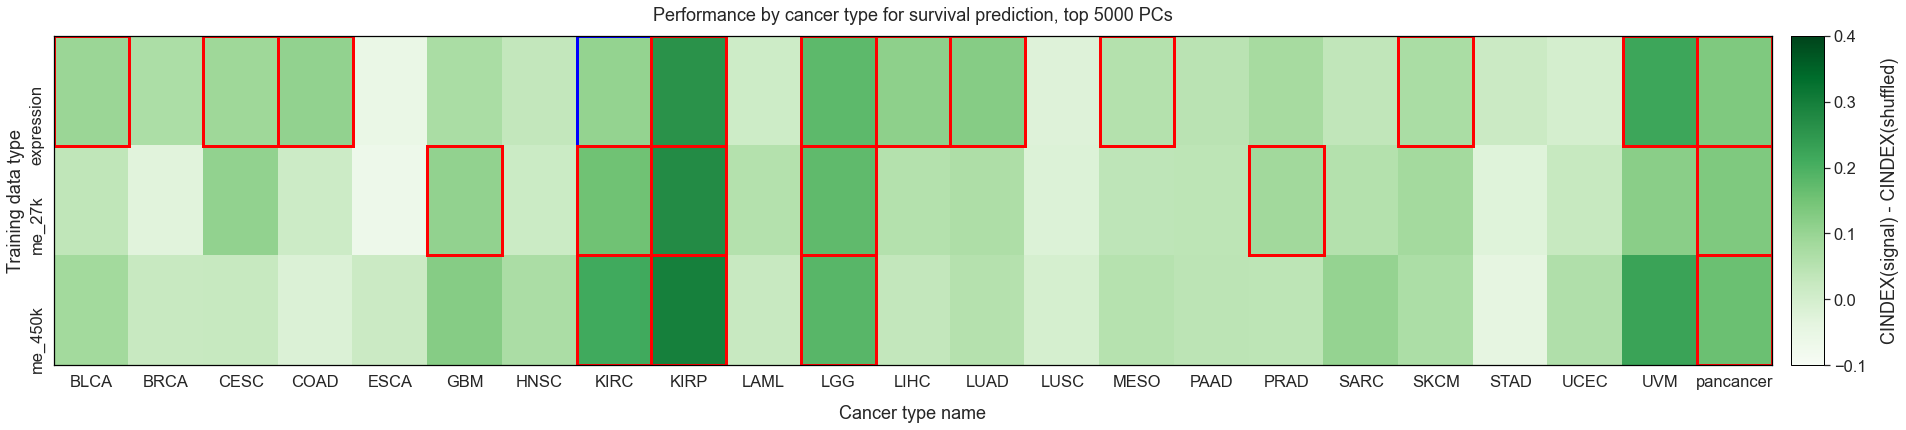

In [13]:
sns.set({'figure.figsize': (28, 6)})
sns.set_context('notebook', font_scale=1.5)

ax = plu.plot_heatmap(me_heatmap_df,
                      me_all_results_df.reset_index(drop=True),
                      different_from_best=True,
                      raw_results_df=raw_results_df,
                      metric='cindex',
                      id_name='cancer_type',
                      scale=(-0.1, 0.4))

plt.title('Performance by cancer type for survival prediction, {}'.format(me_results_desc), pad=15)
if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'survival_me_heatmap.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'survival_me_heatmap.png',
                dpi=300, bbox_inches='tight')

expression: 12/23
me_27k: 6/23
me_450k: 4/23


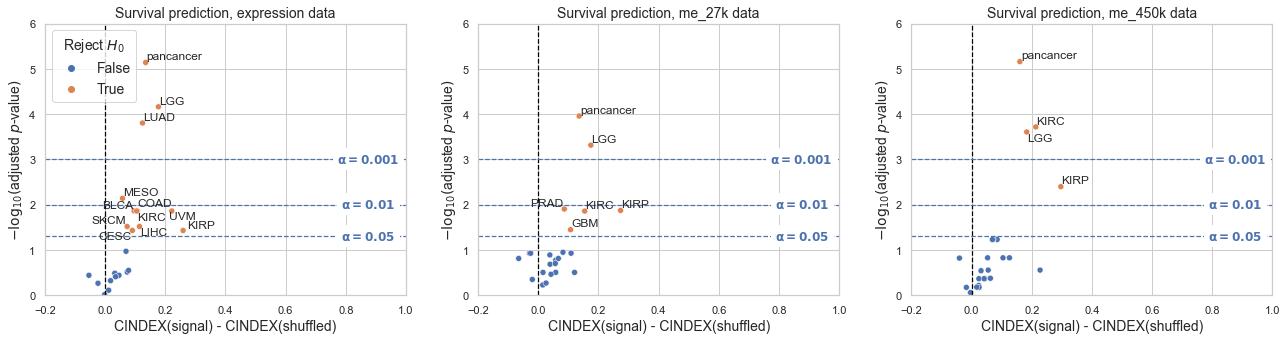

In [14]:
sns.set()
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# just use shortened data type names
training_data_map = {k: k for k in sorted(me_all_results_df.training_data.unique())}

plu.plot_volcano_baseline(me_all_results_df,
                          axarr,
                          training_data_map,
                          SIG_ALPHA,
                          identifier='cancer_type',
                          metric='cindex',
                          predict_str='Survival prediction',
                          verbose=True,
                          ylim=(0, 6))

if SAVE_FIGS:
    plt.savefig(images_dir / 'me_vs_shuffled_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'me_vs_shuffled_survival.png',
                dpi=300, bbox_inches='tight')

### Same plots, for all data types

In [15]:
# set results directory
all_results_dir = Path(cfg.repo_root,
                       '06_predict_survival',
                       'results',
                       'all_data_types',
                       'results_5000_pca').resolve()
all_results_desc = 'top 5000 PCs'

# load results into a single dataframe
all_data_results_df = su.load_survival_results(all_results_dir)
all_data_results_df.rename(columns={'identifier': 'cancer_type',
                                   'fold_no': 'fold'}, inplace=True)
all_data_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.50000,train,MESO,mirna,signal,42,0
1,0.50000,cv,MESO,mirna,signal,42,0
2,0.50000,test,MESO,mirna,signal,42,0
3,0.86667,train,MESO,mirna,signal,42,1
4,0.86667,cv,MESO,mirna,signal,42,1


### Check model convergence results, all data types

In [16]:
all_data_count_df = (all_data_results_df[all_data_results_df.data_type == 'test']
    .groupby(['cancer_type', 'training_data'])
    .count()
)
problem_df = all_data_count_df[all_data_count_df['cindex'] != 16].copy()
print(len(problem_df), '/', len(all_data_count_df))
problem_df

28 / 162


cindex  data_type  signal  seed  fold
cancer_type training_data                                       
ACC         me_27k             12         12      12    12    12
BRCA        mut_sigs           12         12      12    12    12
CESC        expression         12         12      12    12    12
            me_27k             12         12      12    12    12
            me_450k            12         12      12    12    12
            mirna              12         12      12    12    12
            mut_sigs           12         12      12    12    12
            rppa               12         12      12    12    12
CHOL        me_27k             12         12      12    12    12
            me_450k            12         12      12    12    12
ESCA        mirna              12         12      12    12    12
KIRC        mut_sigs           12         12      12    12    12
KIRP        mut_sigs            8          8       8     8     8
LUSC        me_450k            12         12      12    12    12
MESO        me_27k             12         12      12    12    12
PAAD        me_27k             12         12      12    12    12
            me_450k             8          8       8     8     8
READ        expression         12         12      12    12    12
            me_27k              8          8       8     8     8
            me_450k            12         12      12    12    12
            mirna              12         12      12    12    12
            mut_sigs           12         12      12    12    12
            rppa               12         12      12    12    12
TGCT        me_27k             12         12      12    12    12
            me_450k            12         12      12    12    12
THYM        me_27k             12         12      12    12    12
            mut_sigs            8          8       8     8     8
UCS         expression         12         12      12    12    12

In [17]:
drop_cancer_types = problem_df.index.get_level_values(0).unique().values
print(drop_cancer_types)

['ACC' 'BRCA' 'CESC' 'CHOL' 'ESCA' 'KIRC' 'KIRP' 'LUSC' 'MESO' 'PAAD'
 'READ' 'TGCT' 'THYM' 'UCS']


### Plot raw survival prediction results, all data types

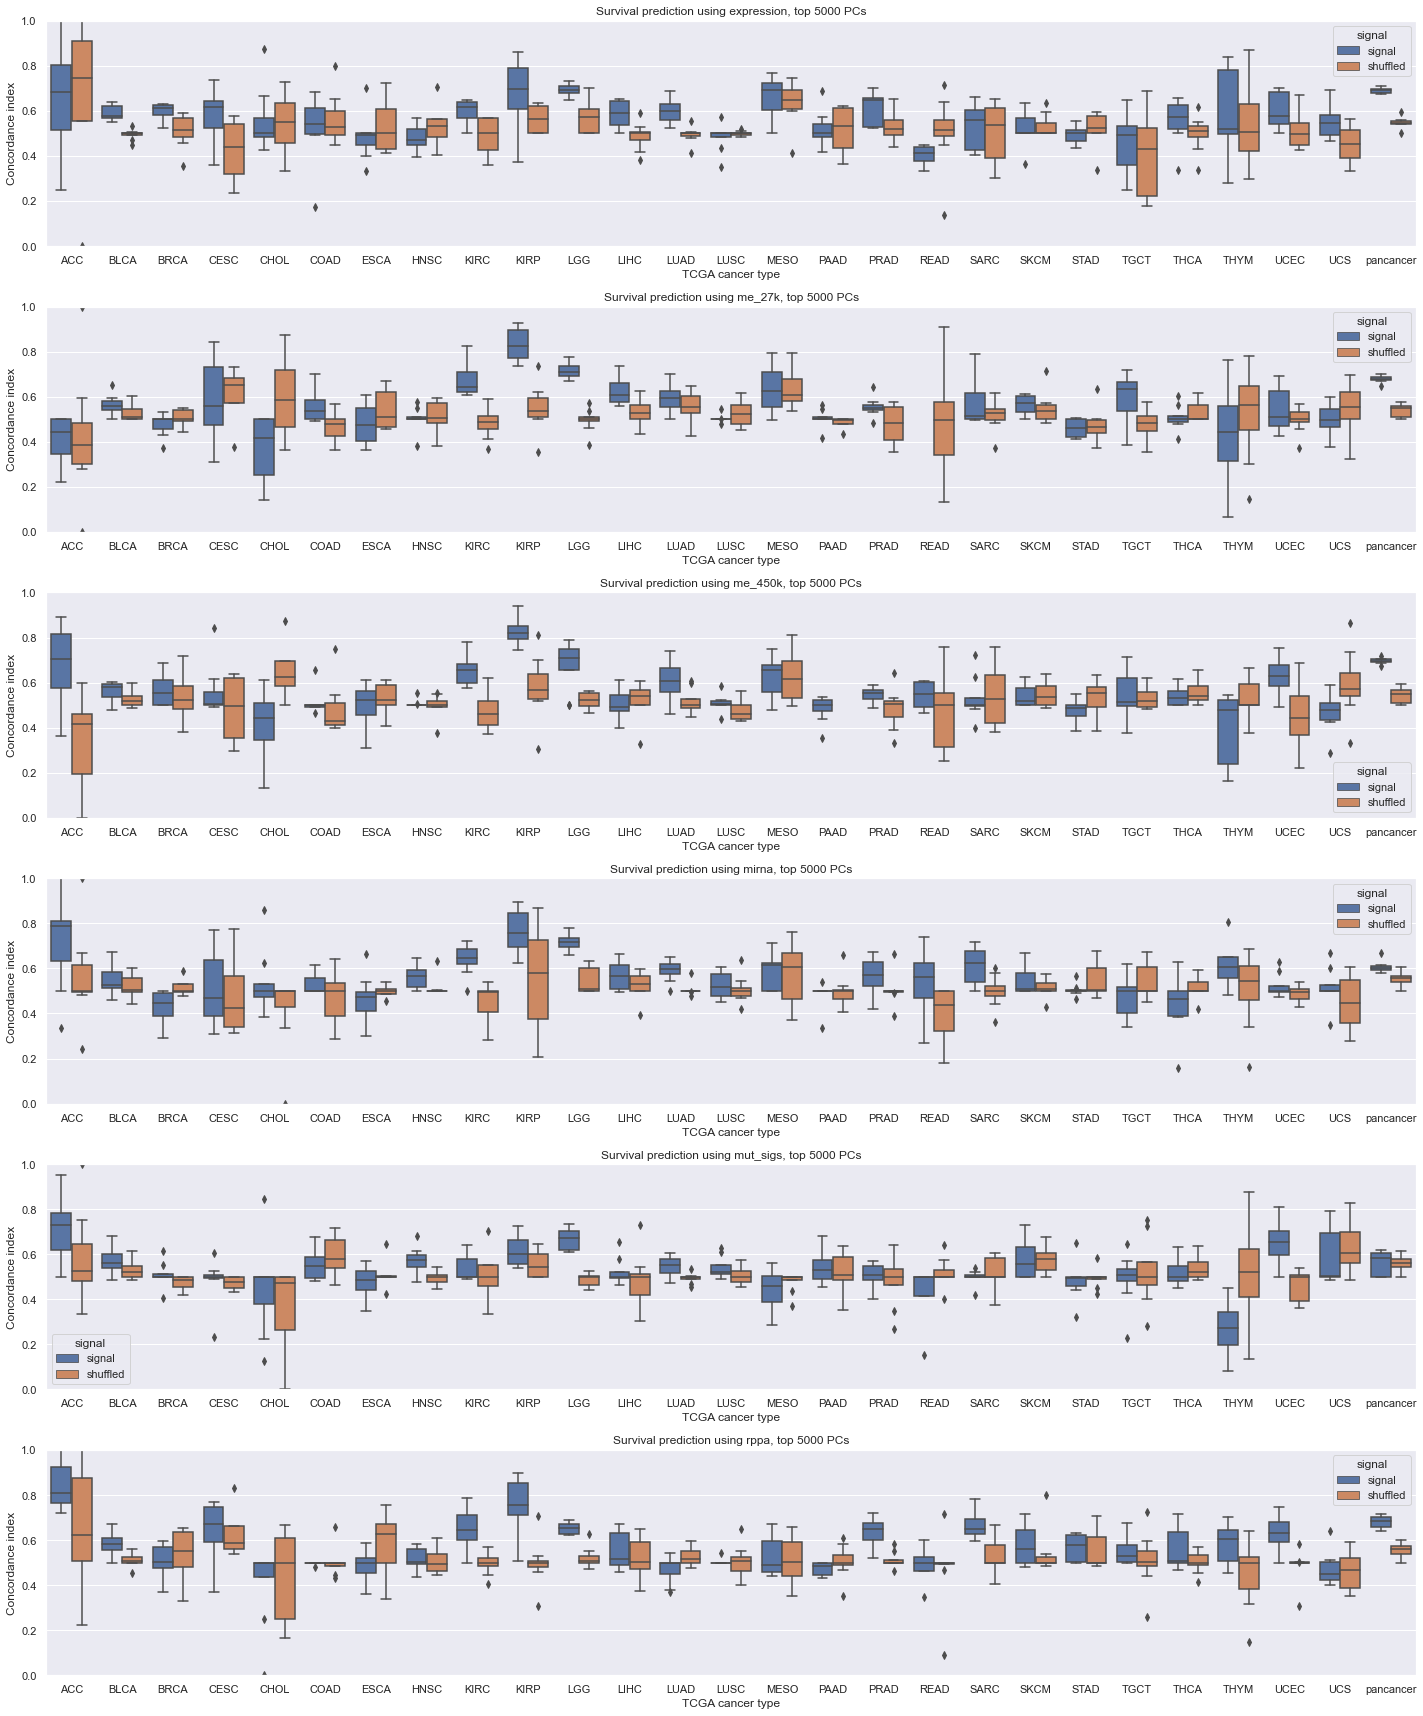

In [18]:
sns.set()
sns.set({'figure.figsize': (20, 24)})
fig, axarr = plt.subplots(6, 1)

for ix, data_type in enumerate(
    all_data_results_df.training_data.sort_values().unique()
):
    
    ax = axarr[ix]
    
    filtered_df = all_data_results_df[
        (all_data_results_df.training_data == data_type) &
        (all_data_results_df.data_type == 'test')
    ].copy()

    filtered_df.sort_values(by='cancer_type', inplace=True)

    sns.boxplot(data=filtered_df, x='cancer_type', y='cindex', hue='signal',
                hue_order=['signal', 'shuffled'], ax=ax)
    ax.set_xlabel('TCGA cancer type')
    ax.set_ylabel('Concordance index')
    ax.set_title('Survival prediction using {}, {}'.format(data_type,
                                                           all_results_desc))
    ax.set_ylim(0.0, 1.0)
    
plt.tight_layout()

In [19]:
all_data_results_df['identifier'] = (all_data_results_df.cancer_type + '_' +
                               all_data_results_df.training_data)
all_data_results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold,identifier
0,0.50000,train,MESO,mirna,signal,42,0,MESO_mirna
1,0.50000,cv,MESO,mirna,signal,42,0,MESO_mirna
2,0.50000,test,MESO,mirna,signal,42,0,MESO_mirna
3,0.86667,train,MESO,mirna,signal,42,1,MESO_mirna
4,0.86667,cv,MESO,mirna,signal,42,1,MESO_mirna


In [20]:
all_data_compare_df = au.compare_control_ind(all_data_results_df,
                                       identifier='identifier',
                                       metric='cindex',
                                       verbose=True)
all_data_compare_df['cancer_type'] = all_data_compare_df.identifier.str.split('_', 1, expand=True)[0]
all_data_compare_df['training_data'] = all_data_compare_df.identifier.str.split('_', 1, expand=True)[1]

print(len(all_data_compare_df))
all_data_compare_df.head()

shapes unequal for ACC_me_27k, skipping
shapes unequal for BRCA_mut_sigs, skipping
shapes unequal for CESC_expression, skipping
shapes unequal for CESC_me_27k, skipping
shapes unequal for CESC_me_450k, skipping
shapes unequal for CESC_mirna, skipping
shapes unequal for CESC_mut_sigs, skipping
shapes unequal for CESC_rppa, skipping
shapes unequal for CHOL_me_27k, skipping
shapes unequal for CHOL_me_450k, skipping
shapes unequal for ESCA_mirna, skipping
shapes unequal for KIRC_mut_sigs, skipping
shapes unequal for LUSC_me_450k, skipping
shapes unequal for MESO_me_27k, skipping
shapes unequal for PAAD_me_27k, skipping
shapes unequal for PAAD_me_450k, skipping
shapes unequal for READ_expression, skipping
shapes unequal for READ_me_27k, skipping
shapes unequal for READ_me_450k, skipping
shapes unequal for READ_mirna, skipping
shapes unequal for READ_mut_sigs, skipping
shapes unequal for READ_rppa, skipping
shapes unequal for TGCT_me_27k, skipping
shapes unequal for TGCT_me_450k, skipping
sh

1080


shapes unequal for UCS_expression, skipping


,identifier,seed,fold,delta_cindex,cancer_type,training_data
0,ACC_expression,42,0,-0.11429,ACC,expression
1,ACC_expression,42,1,0.00000,ACC,expression
2,ACC_expression,42,2,0.77778,ACC,expression
3,ACC_expression,42,3,-0.15556,ACC,expression
4,ACC_expression,1,0,-0.57759,ACC,expression


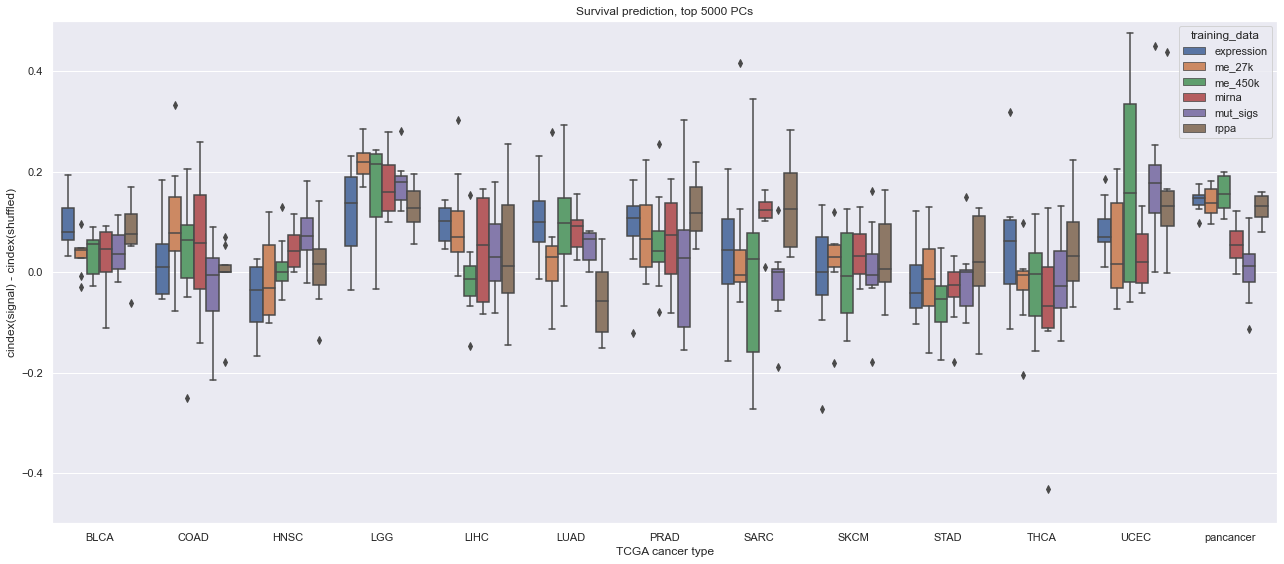

In [21]:
sns.set({'figure.figsize': (18, 8)})
    
all_data_compare_df.sort_values(by='cancer_type', inplace=True)

sns.boxplot(data=all_data_compare_df[~all_data_compare_df.cancer_type.isin(drop_cancer_types)],
            x='cancer_type',
            y='delta_cindex',
            hue='training_data',
            hue_order=sorted(all_data_compare_df.training_data.unique()))
plt.xlabel('TCGA cancer type')
plt.ylabel('cindex(signal) - cindex(shuffled)')
plt.title('Survival prediction, {}'.format(all_results_desc))
plt.ylim(-0.5, 0.5)
    
plt.tight_layout()

### Heatmap, all data types

In [22]:
all_data_all_results_df = au.compare_all_data_types(all_data_results_df[~all_data_results_df.cancer_type.isin(drop_cancer_types)],
                                                    SIG_ALPHA,
                                                    identifier='cancer_type',
                                                    metric='cindex')

all_data_all_results_df.rename(columns={'gene': 'cancer_type'}, inplace=True)
all_data_all_results_df.sort_values(by='p_value').head(10)

,cancer_type,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
12,pancancer,0.142350,6.434972e-07,0.000008,True,expression,5.077510
3,LGG,0.218446,7.259853e-07,0.000009,True,me_27k,5.025129
12,pancancer,0.140005,3.571914e-06,0.000023,True,me_27k,4.634186
12,pancancer,0.127583,4.355788e-06,0.000057,True,rppa,4.246990
12,pancancer,0.155315,1.070547e-05,0.000139,True,me_450k,3.856451
3,LGG,0.179115,1.772863e-05,0.000230,True,mut_sigs,3.637381
3,LGG,0.130178,1.188075e-04,0.000772,True,rppa,3.112243
3,LGG,0.170550,1.209882e-04,0.001573,True,mirna,2.803314
4,LIHC,0.096730,1.842245e-04,0.001197,True,expression,2.921739
7,SARC,0.114078,2.476011e-04,0.001609,True,mirna,2.793334


In [23]:
all_data_heatmap_df = (all_data_all_results_df
    .pivot(index='training_data', columns='cancer_type', values='delta_mean')
    .reindex(sorted(all_data_compare_df.training_data.unique()))
)
all_data_heatmap_df.iloc[:, :5]

cancer_type,BLCA,COAD,HNSC,LGG,LIHC
training_data,,,,,
expression,0.096399,-0.044080,-0.049357,0.117929,0.096730
me_27k,0.035399,0.100643,-0.011424,0.218446,0.096908
me_450k,0.036038,0.028313,0.011056,0.156856,-0.010881
mirna,0.026844,0.056387,0.045667,0.170550,0.045899
mut_sigs,0.040795,-0.034083,0.077491,0.179115,0.038949
rppa,0.078206,-0.006994,0.008130,0.130178,0.035305


In [24]:
raw_results_df = (all_data_results_df
    .drop(columns=['identifier'])
    .rename(columns={'cancer_type': 'identifier'})
)
raw_results_df.head()

,cindex,data_type,identifier,training_data,signal,seed,fold
0,0.50000,train,MESO,mirna,signal,42,0
1,0.50000,cv,MESO,mirna,signal,42,0
2,0.50000,test,MESO,mirna,signal,42,0
3,0.86667,train,MESO,mirna,signal,42,1
4,0.86667,cv,MESO,mirna,signal,42,1


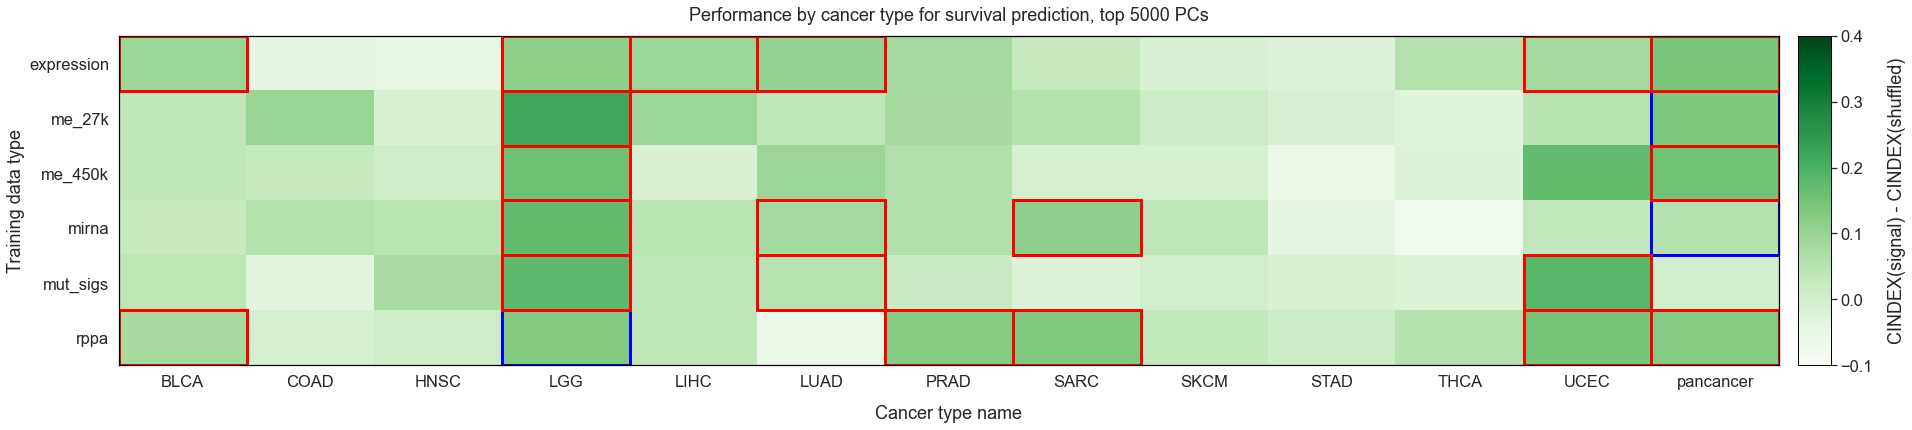

In [25]:
sns.set({'figure.figsize': (28, 6)})
sns.set_context('notebook', font_scale=1.5)

ax = plu.plot_heatmap(all_data_heatmap_df,
                      all_data_all_results_df.reset_index(drop=True),
                      different_from_best=True,
                      raw_results_df=raw_results_df,
                      metric='cindex',
                      id_name='cancer_type',
                      scale=(-0.1, 0.4))

plt.title('Performance by cancer type for survival prediction, {}'.format(all_results_desc), pad=15)
if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'survival_all_heatmap.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'survival_all_heatmap.png',
                dpi=300, bbox_inches='tight')

expression: 6/13
me_27k: 2/13
me_450k: 2/13
mirna: 4/13
mut_sigs: 3/13
rppa: 6/13


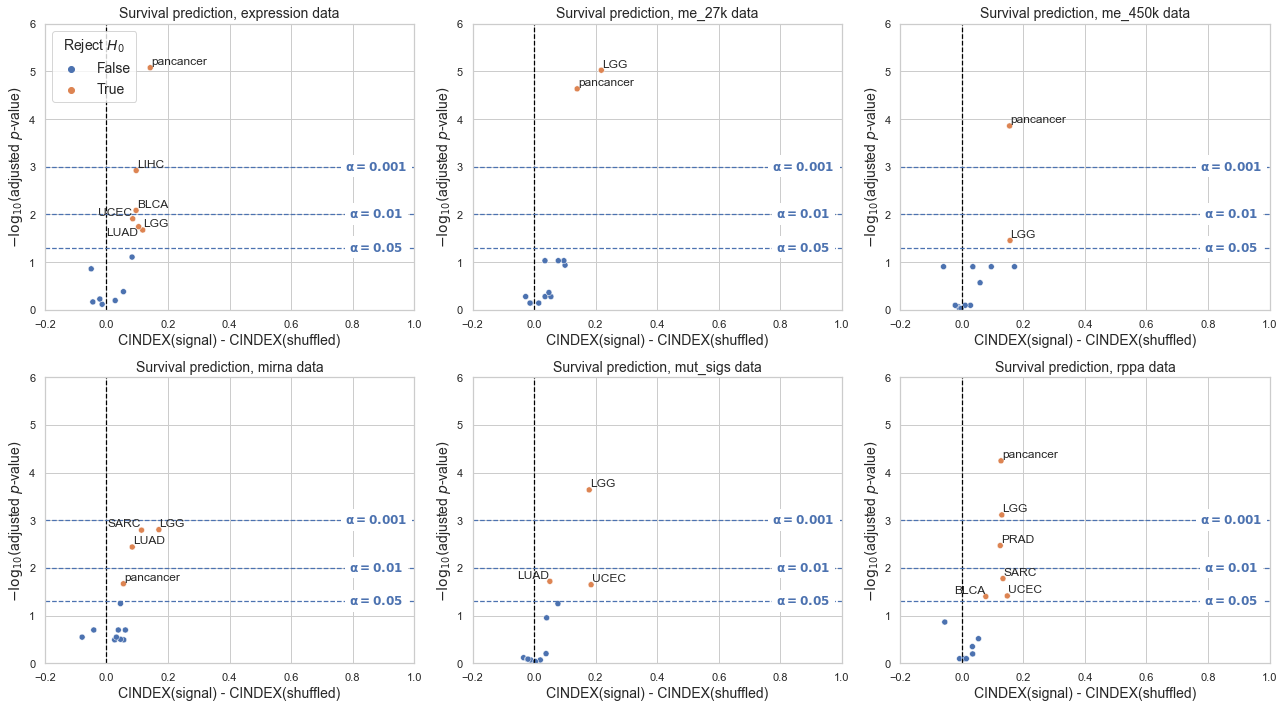

In [26]:
sns.set()
sns.set({'figure.figsize': (18, 10)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 3)

# just use shortened data type names
training_data_map = {k: k for k in sorted(all_data_all_results_df.training_data.unique())}

plu.plot_volcano_baseline(all_data_all_results_df,
                          axarr,
                          training_data_map,
                          SIG_ALPHA,
                          identifier='cancer_type',
                          metric='cindex',
                          predict_str='Survival prediction',
                          verbose=True,
                          ylim=(0, 6))

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_vs_shuffled_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_vs_shuffled_survival.png',
                dpi=300, bbox_inches='tight')

### Plot survival curves

Just looking at a few of these for BRCA now, as a sanity check.

In [27]:
import os
import pickle as pkl

fold = 1
signal = 'signal'
functions_file = os.path.join(cfg.repo_root,
                              'test_results_100',
                              'BRCA_survival_{}_fold{}_functions.pkl'.format(
                                  signal, fold))

with open(functions_file, 'rb') as f:
    fns_dict = pkl.load(f)
    
samples = fns_dict['samples']
fns = fns_dict['functions']
print(len(fns))

168


In [28]:
# get clinical info for BRCA samples
# this includes age, subtype, etc.
clinical_df = pd.read_excel(cfg.clinical_data,
                            sheet_name='TCGA-CDR',
                            index_col='bcr_patient_barcode',
                            engine='openpyxl')

clinical_df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
clinical_df.rename(columns={'age_at_initial_pathologic_diagnosis': 'age'}, inplace=True)

print(clinical_df.shape)
clinical_df.head()

(11160, 32)


,type,age,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,[Not Available],...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2004.0,[Not Available],...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2008.0,[Not Available],...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,[Not Available],...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,[Not Available],...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


In [29]:
ages = clinical_df.loc[~clinical_df.age.isna(), 'age']
print(ages.isna().sum())
ages.head()

0


bcr_patient_barcode
TCGA-OR-A5J1    58.0
TCGA-OR-A5J2    44.0
TCGA-OR-A5J3    23.0
TCGA-OR-A5J4    23.0
TCGA-OR-A5J5    30.0
Name: age, dtype: float64

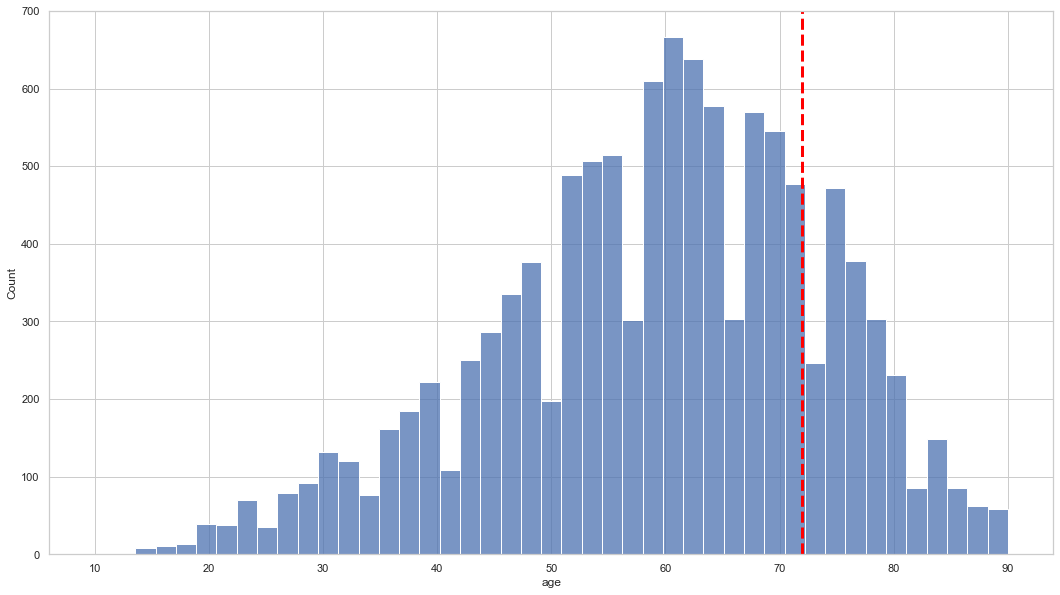

In [30]:
sns.histplot(ages)
qs_age = []
for q in [0.8]:
    q_age = np.quantile(ages, q)
    qs_age.append(q_age)
    plt.gca().axvline(q_age, color='red', linestyle='--', linewidth=3)

In [31]:
age_quantiles = np.digitize(ages.values, qs_age)
ages = pd.DataFrame(ages)
ages['age_quantile'] = age_quantiles
ages.head(n=10)

,age,age_quantile
bcr_patient_barcode,,
TCGA-OR-A5J1,58.0,0
TCGA-OR-A5J2,44.0,0
TCGA-OR-A5J3,23.0,0
TCGA-OR-A5J4,23.0,0
TCGA-OR-A5J5,30.0,0
TCGA-OR-A5J6,29.0,0
TCGA-OR-A5J7,30.0,0
TCGA-OR-A5J8,66.0,0
TCGA-OR-A5J9,22.0,0


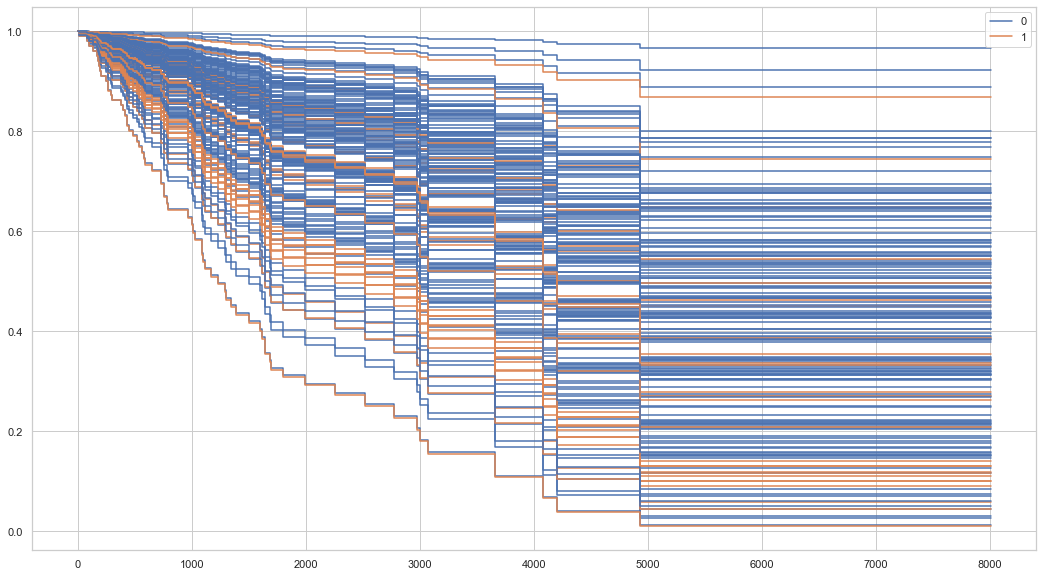

In [32]:
# color by age binned into quantiles
for ix in range(len(fns)):
    fn = fns[ix]
    sample_id = '-'.join(samples[ix].split('-')[:3])
    sample_age_quantile = int(ages.loc[sample_id, 'age_quantile'])
    plt.step(fn.x, fn.y, label=sample_age_quantile,
             color='C{:d}'.format(sample_age_quantile))
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())